In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree, remove_self_loops, add_self_loops
from torch_geometric.nn import GATConv

class GATNet(nn.Module):
    def __init__(self):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(dataset.num_features, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8*8, dataset.num_classes, dropout=0.6)

    def forward(self, data):
        x = F.dropout(data.x, p=0.4, training=self.training)
        x = F.relu(self.conv1(x, data.edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, data.edge_index)
        return F.log_softmax(x, dim=1)

In [1]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.9 MB/s eta 0:00:00


In [3]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='./dataset/Pubmed', name='Pubmed')

Processing...
Done!


In [5]:
import os

# Directory path
directory = 'LossAndAccuracy'

# Create directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATNet().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

filename = 'LossAndAccuracy/GAT_Pubmed.txt'

model.train()
for epoch in range(2000):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / data.test_mask.sum().item()

    with open(filename,'a') as f: # 'a' means append, which means continuing to write data after the original file content (the original data is not clear)
        f.write('{:02d} {:.4f} {:.4f}\n'.format(epoch, loss, acc))

Test Model

In [7]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.6680


Draw Curve

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
data_cora =np.loadtxt("LossAndAccuracy/GAT_Pubmed.txt")

x = data_cora[:,0] # epoch
y1 = data_cora[:,1] # loss
y2 = data_cora[:,2] # accuracy

Text(0.5, 1.0, 'loss for training GAT on pubmed')

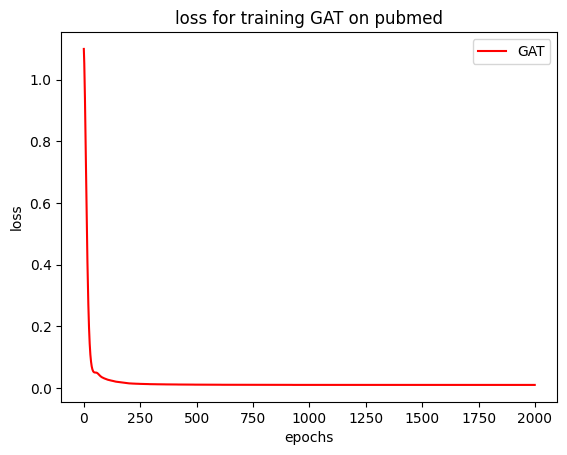

In [9]:
# Draw the overall loss curve

p2 = pl.plot(x, y1,'r-', label = u'GAT')
pl.legend()

pl.xlabel(u'epochs')
pl.ylabel(u'loss')
plt.title('loss for training GAT on pubmed')

Text(0.5, 1.0, 'accuracy for training GAT on pubmed')

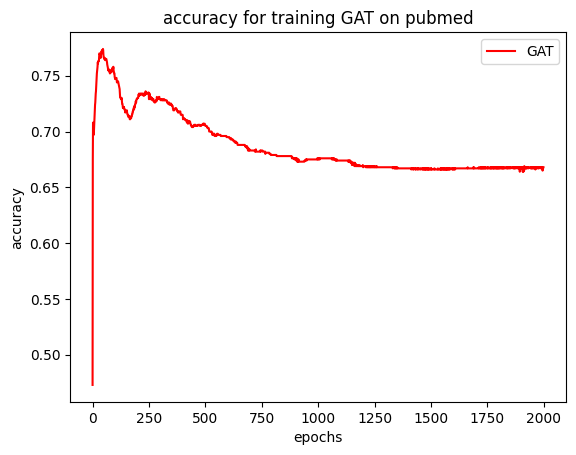

In [10]:
# Draw the overall accuracy curve

p2 = pl.plot(x, y2,'r-', label = u'GAT')
pl.legend()
#Show legend
pl.xlabel(u'epochs')
pl.ylabel(u'accuracy')
plt.title('accuracy for training GAT on pubmed')

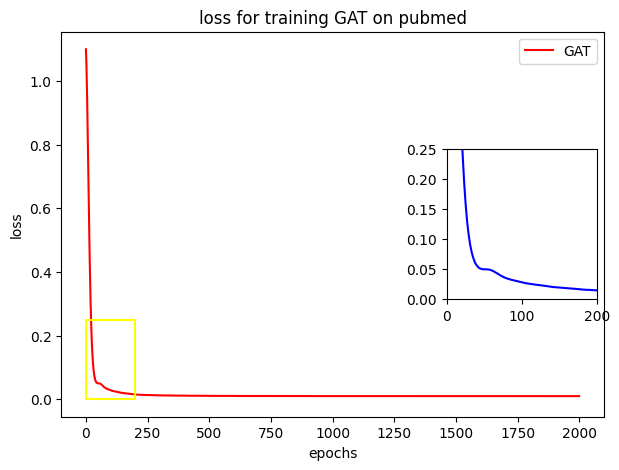

In [11]:
fig1 = plt.figure(figsize = (7,5)) # figsize is the size of the picture
ax1 = fig1.add_subplot(1, 1, 1) # ax1 is the name of the subgraph

# Draw the overall loss curve
p2 = pl.plot(x, y1,'r-', label = u'GAT')
pl.legend()
#Show legend
pl.xlabel(u'epochs')
pl.ylabel(u'loss')
plt.title('loss for training GAT on pubmed')

# Show an enlarged portion of the curve
tx0 = 0
tx1 = 200
ty0 = 0.000
ty1 = 0.25
sx = [tx0,tx1,tx1,tx0,tx0]
sy = [ty0,ty0,ty1,ty1,ty0]
pl.plot(sx,sy,"yellow")
axins = inset_axes(ax1, width=1.5, height=1.5, loc='right')

axins.plot(x,y1, color='blue', ls='-')
axins.axis([0, 200, 0.00, 0.25])
pl.show()

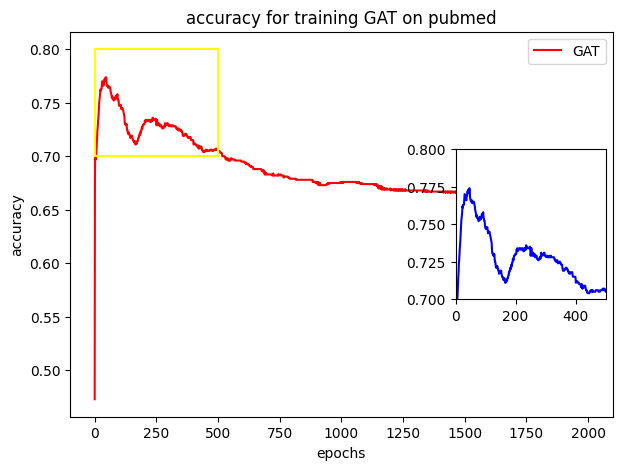

In [12]:
fig1 = plt.figure(figsize = (7,5)) # figsize is the size of the picture
ax1 = fig1.add_subplot(1, 1, 1) # ax1 is the name of the subgraph

# Draw the overall loss curve

p2 = pl.plot(x, y2,'r-', label = u'GAT')
pl.legend()
#Show legend
pl.xlabel(u'epochs')
pl.ylabel(u'accuracy')
plt.title('accuracy for training GAT on pubmed')

# Show an enlarged portion of the curve
tx0 = 0
tx1 = 500
#Set the abscissa range of the area you want to enlarge
ty0 = 0.70
ty1 = 0.80
#Set the vertical coordinate range of the area you want to enlarge
sx = [tx0,tx1,tx1,tx0,tx0]
sy = [ty0,ty0,ty1,ty1,ty0]
pl.plot(sx,sy,"yellow")
axins = inset_axes(ax1, width=1.5, height=1.5, loc='right')

axins.plot(x,y2, color='blue', ls='-')
axins.axis([0, 500, 0.70, 0.80])
pl.show()

In [13]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.att_src 	 torch.Size([1, 8, 8])
conv1.att_dst 	 torch.Size([1, 8, 8])
conv1.bias 	 torch.Size([64])
conv1.lin.weight 	 torch.Size([64, 500])
conv2.att_src 	 torch.Size([1, 1, 3])
conv2.att_dst 	 torch.Size([1, 1, 3])
conv2.bias 	 torch.Size([3])
conv2.lin.weight 	 torch.Size([3, 64])
Optimizer's state_dict:
state 	 {0: {'step': tensor(2000.), 'exp_avg': tensor([[[-3.2260e-37, -9.8091e-45,  2.8231e-13,  1.7336e-12,  2.3611e-12,
          -6.0341e-17,  3.9427e-13,  2.9157e-12],
         [ 1.4688e-11,  5.0875e-11, -5.3330e-11,  6.2878e-14,  3.5322e-17,
          -6.7802e-13,  4.2795e-11,  2.3980e-11],
         [ 2.2009e-11, -7.9685e-13, -7.0898e-12, -1.5208e-11, -1.1739e-11,
           2.2779e-11, -5.1764e-12,  1.4647e-13],
         [ 5.3057e-07, -1.4919e-06,  1.0629e-06,  2.0083e-07,  4.7345e-07,
           3.9869e-07, -1.1144e-06, -4.8126e-07],
         [-3.0799e-07, -1.9645e-07,  3.9937e-07, -1.4953e-07,  5.0103e-07,
           5.6836e-07, -3.8413e-07,  4.6258

In [14]:
torch.save(model.state_dict(),'GATpubmed.pkl')

Spectral Clustering

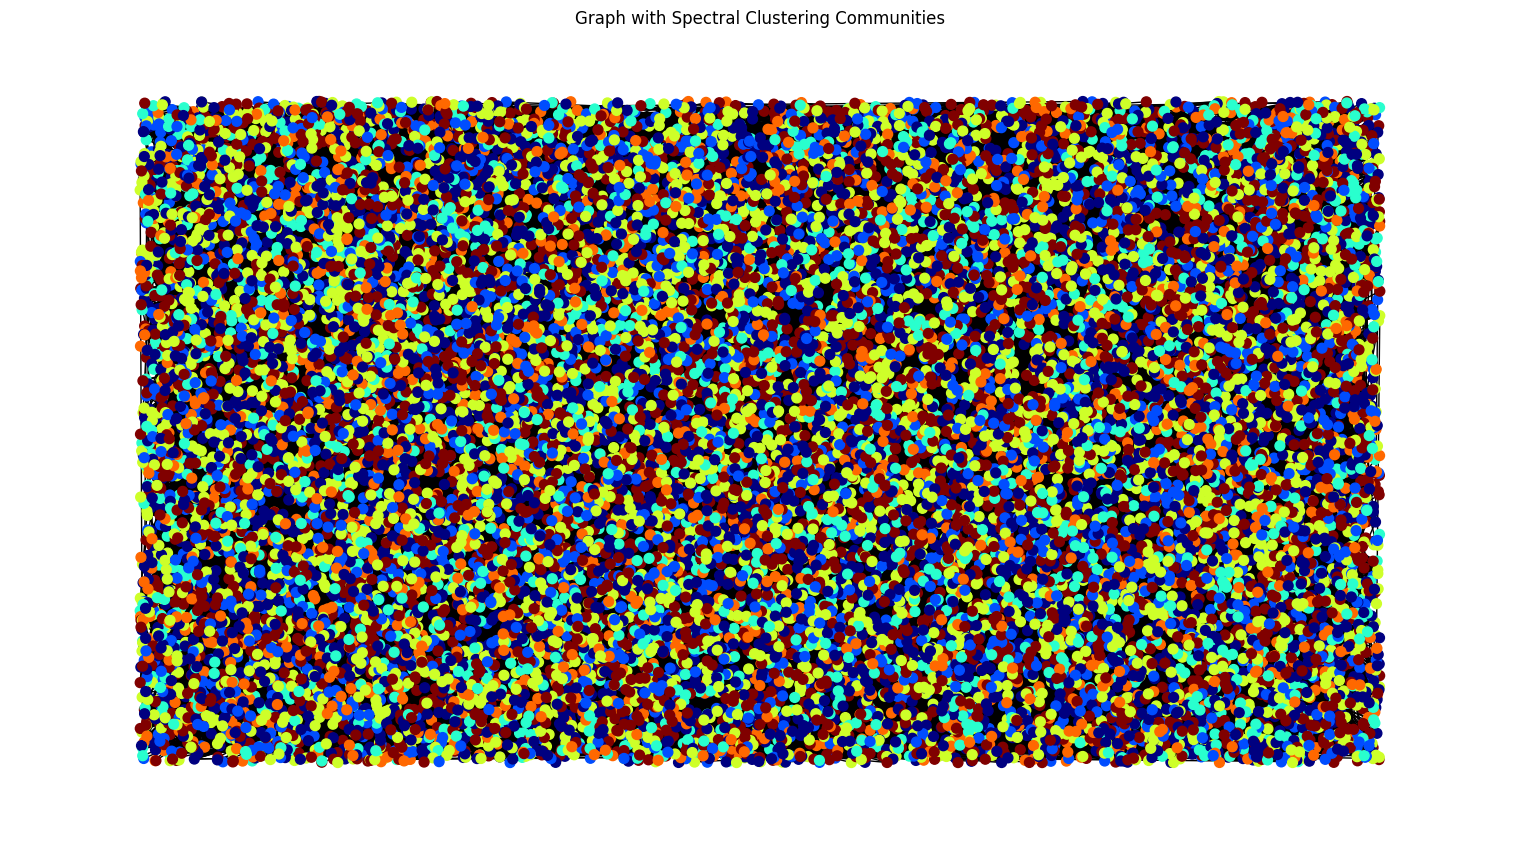

In [15]:
import torch
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Extract features from the trained GAT model
with torch.no_grad():
    model.eval()
    features = model(data).cpu().numpy()

# Step 2: Perform spectral clustering
n_clusters = 6  # Number of clusters (you can adjust this according to your requirement)
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0)
cluster_labels = sc.fit_predict(features)

# Step 3: Create a graph using networkx
G = nx.Graph()
edges = data.edge_index.t().cpu().numpy()
G.add_edges_from(edges)

# Step 4: Draw the graph with node colors representing the clusters
plt.ioff()  # Turn off interactive mode for plotting
plt.figure(figsize=(15, 8))
pos = nx.random_layout(G)  # Use a simpler layout algorithm
nx.draw(G, pos, node_color=cluster_labels, cmap=plt.cm.jet, node_size=50, with_labels=False)
plt.title("Graph with Spectral Clustering Communities")
plt.show()

In [20]:
import numpy as np
import networkx as nx

def compute_density(graph, communities):
    num_edges_within_communities = sum(len(graph.subgraph(community).edges()) for community in communities)
    num_nodes_within_communities = sum(len(community) for community in communities)
    total_possible_edges_within_communities = num_nodes_within_communities * (num_nodes_within_communities - 1) / 2
    density = num_edges_within_communities / total_possible_edges_within_communities
    return density

def compute_entropy(community_labels):
    num_nodes = len(community_labels)
    unique_labels, label_counts = np.unique(community_labels, return_counts=True)
    proportions = label_counts / num_nodes
    entropy = -np.sum(proportions * np.log(proportions))
    return entropy

def compute_modularity(graph, community_labels):
    num_edges = graph.number_of_edges()
    num_nodes = graph.number_of_nodes()
    modularity = nx.algorithms.community.modularity(graph, [set(np.where(community_labels == i)[0]) for i in np.unique(community_labels)])
    return modularity

def compute_conductance(graph, communities):
    cut_size = sum(nx.algorithms.cuts.cut_size(graph, community, graph.nodes - set(community)) for community in communities)
    volume = sum(nx.algorithms.cuts.volume(graph, community) for community in communities)
    if volume == 0:  # Avoid division by zero
        conductance = float('inf')
    else:
        conductance = cut_size / volume
    return conductance

# Assuming 'G' is the graph and 'cluster_labels' contains the predicted cluster labels
communities = [set(np.where(cluster_labels == i)[0]) for i in np.unique(cluster_labels)]
density = compute_density(G, communities)
entropy = compute_entropy(cluster_labels)
modularity = compute_modularity(G, cluster_labels)
conductance = compute_conductance(G, communities)
print(f"Overall: Density={density:.4f}, Entropy={entropy:.4f}, Modularity={modularity:.4f}, Conductance={conductance:.4f}")


Overall: Density=0.0001, Entropy=1.7381, Modularity=0.3865, Conductance=0.4319


In [ ]:
# Add cluster labels as node attributes
for node, cluster_label in enumerate(cluster_labels):
    G.nodes[node]['cluster_label'] = cluster_label

# Save the graph as a GEXF file in Colab with node attributes
nx.write_gexf(G, "/content/graph_with_clusters.gexf")

# Download the file to your local computer
from google.colab import files
files.download("/content/graph_with_clusters.gexf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 5: Compute ARI and NMI
# Ground truth labels for communities (assuming you have them)
ground_truth_labels = data.y.cpu().numpy()
ari = adjusted_rand_score(ground_truth_labels, cluster_labels)
nmi = normalized_mutual_info_score(ground_truth_labels, cluster_labels)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)

Adjusted Rand Index (ARI): 0.13617903276436183
Normalized Mutual Information (NMI): 0.19134449285283267


K means Clustering (Finding value of k using elbow method)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

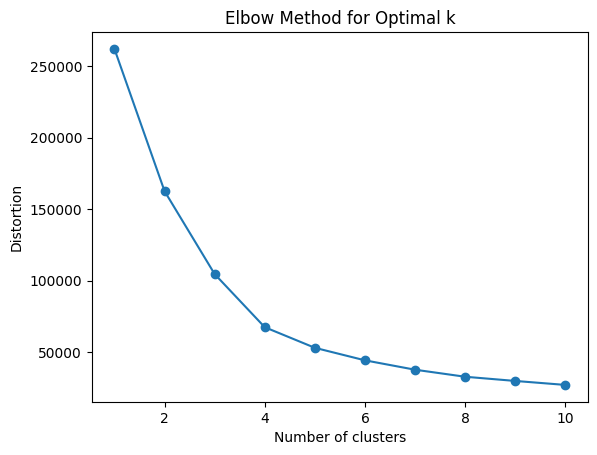

In [21]:
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Extract output features from the GAT model
with torch.no_grad():
    model.eval()
    output_features = model(data).cpu().numpy()

# Step 2: Perform K-means clustering
def kmeans_clustering(features, k):
    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(features)
    return clusters

# Step 3: Utilize the elbow method to determine the optimal value of K
def elbow_method(features, max_k=10):
    distortions = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(features)
        distortions.append(kmeans.inertia_)
    plt.plot(range(1, max_k + 1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal k')
    plt.show()

elbow_method(output_features)

# Step 4: Visualize the detected communities
def visualize_clusters(features, clusters):
    # Visualization code here, depending on the dimensionality of features
    # For example, if features are 2D, you can scatter plot them and color them based on clusters
    plt.scatter(features[:, 0], features[:, 1], c=clusters, cmap='viridis')
    plt.title('Detected Communities')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()


In [22]:
# Choose the optimal value of K based on the elbow method
optimal_k = 6  # Adjust this based on the elbow method plot

# Perform K-means clustering with the optimal value of K
clusters = kmeans_clustering(output_features, optimal_k)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


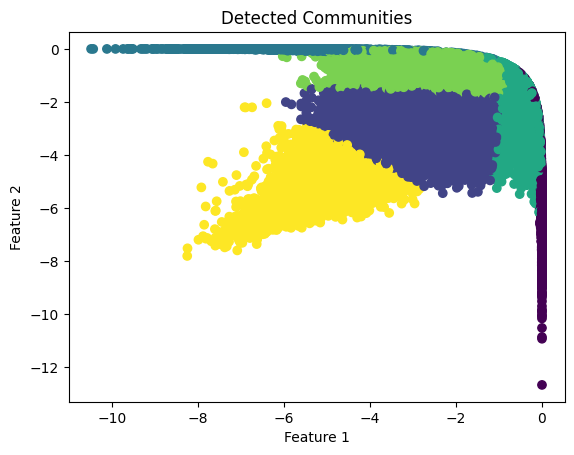

In [23]:
# Step 6: Visualize the detected communities
visualize_clusters(output_features, clusters)

In [31]:
# Extracting number of nodes and edges from the PyTorch Geometric dataset
num_nodes = data.num_nodes
edges = data.edge_index.t().tolist()  # Convert edge_index to a list of tuples

# Assuming G is your NetworkX graph
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)


In [32]:
import numpy as np
import networkx as nx

def calculate_metrics(G, clusters):
    # Density
    density = nx.density(G)

    # Entropy
    num_nodes = len(G.nodes)
    entropy = 0
    for cluster in np.unique(clusters):
        p_i = np.sum(clusters == cluster) / num_nodes
        entropy -= p_i * np.log(p_i)

    # Modularity
    modularity = nx.community.modularity(G, [set(np.where(clusters == i)[0]) for i in np.unique(clusters)])

    # Compute conductance manually
    conductance = calculate_conductance(G, clusters)

    return density, entropy, modularity, conductance

def calculate_conductance(G, clusters):
    conductances = []
    for cluster in np.unique(clusters):
        nodes_in_cluster = set(np.where(clusters == cluster)[0])
        external_edges = sum(1 for u, v in G.edges(nodes_in_cluster) if v not in nodes_in_cluster)
        internal_edges = sum(1 for u, v in G.edges(nodes_in_cluster) if v in nodes_in_cluster)
        if internal_edges != 0:  # Ensure there are internal edges to avoid division by zero
            conductance = external_edges / (internal_edges + external_edges)
            conductances.append(conductance)
    if conductances:
        return np.mean(conductances)
    else:
        return 0  # If there are no edges within any community, return 0 conductance


# Assuming G is your NetworkX graph
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)

# Call the function to calculate metrics
density, entropy, modularity, conductance = calculate_metrics(G, clusters)

print("Density:", density)
print("Entropy:", entropy)
print("Modularity:", modularity)
print("Conductance:", conductance)


Density: 0.00022803908825811382
Entropy: 1.719385797595632
Modularity: 0.3876991669647468
Conductance: 0.5920788491654482


In [ ]:
# Step 5: Obtain ground truth labels for the test set
ground_truth_labels = data.y.cpu().numpy()  # Assuming ground truth labels are for all data samples

# Ensure the ground truth labels match the number of clusters
ground_truth_labels = ground_truth_labels[:len(clusters)]

# Step 6: Calculate Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI)
ari = adjusted_rand_score(ground_truth_labels, clusters)
nmi = normalized_mutual_info_score(ground_truth_labels, clusters)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)


Adjusted Rand Index (ARI): 0.18973851946614415
Normalized Mutual Information (NMI): 0.2249941482183975


In [33]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv
from torch_geometric.utils import to_networkx
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import community.community_louvain as community_louvain

# Step 1: Extract features from the trained GAT model
model.eval()
with torch.no_grad():
    output_features = model(data).cpu().numpy()

# Step 2: Convert PyG graph to NetworkX graph
graph = to_networkx(data, to_undirected=True)

# Step 3: Apply community detection using Louvain method
partition = community_louvain.best_partition(graph)


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


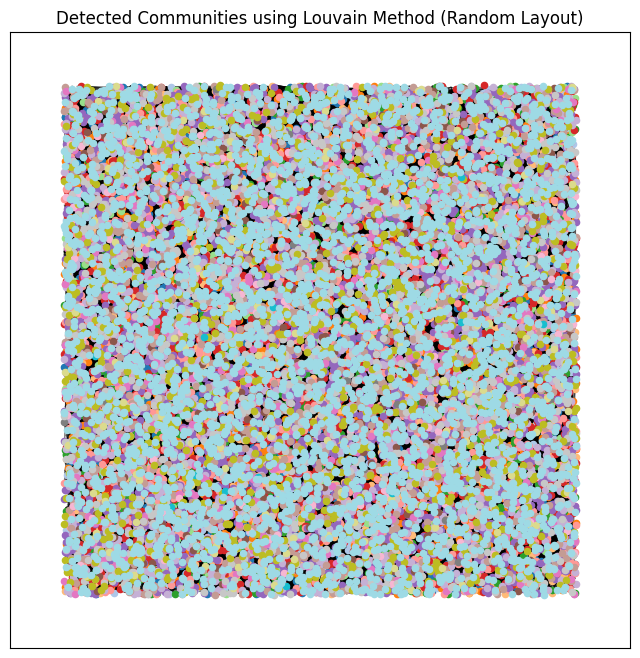

Adjusted Rand Index (ARI): 0.09674320187070247
Normalized Mutual Information (NMI): 0.19955792532571398


In [ ]:
# Step 4: Visualize the detected communities with random layout
plt.figure(figsize=(8, 8))
# Draw nodes for each community with a different color
for community_id in set(partition.values()):
    nodes_in_community = [node for node, comm_id in partition.items() if comm_id == community_id]
    nx.draw_networkx_nodes(graph, pos=nx.random_layout(graph), nodelist=nodes_in_community, node_size=20, node_color=plt.cm.tab20(community_id))
# Draw edges
nx.draw_networkx_edges(graph, pos=nx.random_layout(graph), alpha=0.5)
plt.title('Detected Communities using Louvain Method (Random Layout)')
plt.show()

# Step 5: Calculate ARI and NMI
# Assuming ground truth communities are available in data.y
ground_truth = data.y.numpy()
ari = adjusted_rand_score(ground_truth, list(partition.values()))
nmi = normalized_mutual_info_score(ground_truth, list(partition.values()))

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)


In [ ]:
# Add cluster labels as node attributes
for node, cluster_label in enumerate(cluster_labels):
    G.nodes[node]['cluster_label'] = cluster_label

# Save the graph as a GEXF file in Colab with node attributes
nx.write_gexf(G, "/content/Pubmed-Louvain.gexf")

# Download the file to your local computer
from google.colab import files
files.download("/content/Pubmed-Louvain.gexf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv
from torch_geometric.utils import to_networkx
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain

# Step 1: Extract features from the trained GAT model
model.eval()
with torch.no_grad():
    output_features = model(data).cpu().numpy()

# Step 2: Convert PyG graph to NetworkX graph
graph = to_networkx(data, to_undirected=True)

# Step 3: Apply community detection using Louvain method
partition = community_louvain.best_partition(graph)

def calculate_metrics(graph, partition):
    # Density
    density = nx.density(graph)

    # Entropy
    num_nodes = len(graph.nodes)
    entropy = 0
    for community_id in set(partition.values()):
        p_i = sum(1 for node, comm_id in partition.items() if comm_id == community_id) / num_nodes
        entropy -= p_i * np.log(p_i)

    # Modularity
    modularity = community_louvain.modularity(partition, graph)

    # Compute conductance manually
    conductance = calculate_conductance(graph, partition)

    return density, entropy, modularity, conductance

def calculate_conductance(graph, partition):
    conductances = []
    for community_id in set(partition.values()):
        nodes_in_community = [node for node, comm_id in partition.items() if comm_id == community_id]
        external_edges = sum(1 for u, v in graph.edges(nodes_in_community) if v not in nodes_in_community)
        internal_edges = sum(1 for u, v in graph.edges(nodes_in_community) if v in nodes_in_community)
        if internal_edges != 0:  # Ensure there are internal edges to avoid division by zero
            conductance = external_edges / (internal_edges + external_edges)
            conductances.append(conductance)
    if conductances:
        return np.mean(conductances)
    else:
        return 0  # If there are no edges within any community, return 0 conductance

# Call the function to calculate metrics
density, entropy, modularity, conductance = calculate_metrics(graph, partition)

print("Density:", density)
print("Entropy:", entropy)
print("Modularity:", modularity)
print("Conductance:", conductance)


Density: 0.00022803908825811382
Entropy: 3.0557614117745913
Modularity: 0.7672114228437781
Conductance: 0.24466642874721553
